# Final Project: Facial Keypoints Detection

by Michael Berger, Andre Fernandes, Vivian Lu, and Pauline Wang.

Our project related to the kaggle [facial keypoint detection competition](https://www.kaggle.com/c/facial-keypoints-detection). We need to build a well-performing machine learning system to determine the x and y coordinates of keypoints in an image of a human face (e.g. left eye corner). There are up to 30 keypoints. The problem is a regression problem and in this task we have up to 30 regression outputs to predict (x and y of 15 labels). We will especially focus on practicing **Convolutional Neural Networks**. As baseline model we use xyz. The metric used on teh kaggle competition is the root mean squared error (RMSE) defined as:

$RMSE = \sqrt{ \frac{1}{n} \sum^n_{i=1} (y_i - \hat{y}_i)^2}$

Our analysis is structured as follows:
- We first load the libraries we use as well as the testing and training data.
- We then transform the data in a shape and format useable for us.
- We plot a couple of training images and associated keypoints.
- ...

## Libraries and Data

Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

Left and right here refers to the point of view of the subject.

In some examples, some of the target keypoint positions are misssing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.metrics import classification_report

from keras.models import Sequential 
from keras.layers import Dense, Activation
from keras import optimizers

import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

Using TensorFlow backend.


In [2]:
# not in git repo because of file size...
path_train = '../Data/training/training.csv'
path_test = '../Data/test/test.csv'

df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

In [3]:
df_test.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [4]:
df_train.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [5]:
# positions training
labels = df_train.iloc[:, 0:30]
labels.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [6]:
# processing training data such that each pixel has its own column and is seperated from the labels
kaggle_train = df_train.loc[:,'Image'].T
kaggle_train = kaggle_train.astype(str)
kaggle_train = kaggle_train.str.split(" ", expand = True) 
kaggle_train.head()

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
0,238,236,237,238,240,240,239,241,241,243,...,33,29,30,34,39,49,62,70,75,90
1,219,215,204,196,204,211,212,200,180,168,...,1,1,1,1,1,1,1,1,1,1
2,144,142,159,180,188,188,184,180,167,132,...,64,60,56,61,70,69,71,78,78,77
3,193,192,193,194,194,194,193,192,168,111,...,1,1,1,1,1,1,1,1,1,1
4,147,148,160,196,215,214,216,217,219,220,...,33,34,37,37,43,46,83,140,170,176


In [7]:
# processing test data such that each pixel has its own column,
# merging it then with the ImageId column
image_test = df_test.loc[:,'Image'].T
image_test = image_test.astype(str)
image_test = image_test.str.split(" ", expand = True)
kaggle_test = pd.DataFrame(df_test.loc[:,'ImageId']).join(image_test)
kaggle_test.head()

,ImageId,0,1,2,3,4,5,6,7,8,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
0,1,182,183,182,182,180,180,176,169,156,...,6,14,28,28,24,18,12,8,5,5
1,2,76,87,81,72,65,59,64,76,69,...,156,152,162,169,168,159,191,228,211,168
2,3,177,176,174,170,169,169,168,166,166,...,1,1,1,1,1,1,1,1,1,1
3,4,176,174,174,175,174,174,176,176,175,...,144,143,141,142,143,142,142,142,142,140
4,5,50,47,44,101,144,149,120,58,48,...,254,254,254,253,255,236,174,175,175,165


In [8]:
# Missing values kaggle_training?
kaggle_train.columns[kaggle_train.isna().any()].tolist()

[]

In [9]:
# Missing values in labels?
labels.columns[labels.isna().any()].tolist()

['left_eye_center_x',
 'left_eye_center_y',
 'right_eye_center_x',
 'right_eye_center_y',
 'left_eye_inner_corner_x',
 'left_eye_inner_corner_y',
 'left_eye_outer_corner_x',
 'left_eye_outer_corner_y',
 'right_eye_inner_corner_x',
 'right_eye_inner_corner_y',
 'right_eye_outer_corner_x',
 'right_eye_outer_corner_y',
 'left_eyebrow_inner_end_x',
 'left_eyebrow_inner_end_y',
 'left_eyebrow_outer_end_x',
 'left_eyebrow_outer_end_y',
 'right_eyebrow_inner_end_x',
 'right_eyebrow_inner_end_y',
 'right_eyebrow_outer_end_x',
 'right_eyebrow_outer_end_y',
 'mouth_left_corner_x',
 'mouth_left_corner_y',
 'mouth_right_corner_x',
 'mouth_right_corner_y',
 'mouth_center_top_lip_x',
 'mouth_center_top_lip_y',
 'mouth_center_bottom_lip_x',
 'mouth_center_bottom_lip_y']

In [10]:
kaggle_train.shape

(7049, 9216)

In [11]:
kaggle_test.shape

(1783, 9217)

In [12]:
kaggle_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
count,7049,7049,7049,7049,7049,7049,7049,7049,7049,7049,...,7049,7049,7049,7049,7049,7049,7049,7049,7049,7049
unique,256,256,256,256,256,256,256,256,256,256,...,256,256,256,256,256,256,256,256,256,256
top,255,255,255,255,27,23,22,33,31,29,...,255,255,255,255,255,255,255,255,255,255
freq,157,126,98,82,84,74,79,83,77,80,...,200,223,246,252,270,285,284,301,315,336


In [13]:
labels.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,...,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,...,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,...,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,...,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,...,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,...,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,...,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,...,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


In [14]:
labels.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [15]:
labels.shape

(7049, 30)

In [16]:
#percentage missing per label
labels.isnull().sum() / labels.shape[0]

left_eye_center_x            0.001419
left_eye_center_y            0.001419
right_eye_center_x           0.001844
right_eye_center_y           0.001844
left_eye_inner_corner_x      0.677827
left_eye_inner_corner_y      0.677827
left_eye_outer_corner_x      0.678394
left_eye_outer_corner_y      0.678394
right_eye_inner_corner_x     0.678252
right_eye_inner_corner_y     0.678252
right_eye_outer_corner_x     0.678252
right_eye_outer_corner_y     0.678252
left_eyebrow_inner_end_x     0.677969
left_eyebrow_inner_end_y     0.677969
left_eyebrow_outer_end_x     0.684352
left_eyebrow_outer_end_y     0.684352
right_eyebrow_inner_end_x    0.677969
right_eyebrow_inner_end_y    0.677969
right_eyebrow_outer_end_x    0.682792
right_eyebrow_outer_end_y    0.682792
nose_tip_x                   0.000000
nose_tip_y                   0.000000
mouth_left_corner_x          0.678110
mouth_left_corner_y          0.678110
mouth_right_corner_x         0.677969
mouth_right_corner_y         0.677969
mouth_center

We have missing values in the labels... how to deal with that?

## Plotting some images with face points

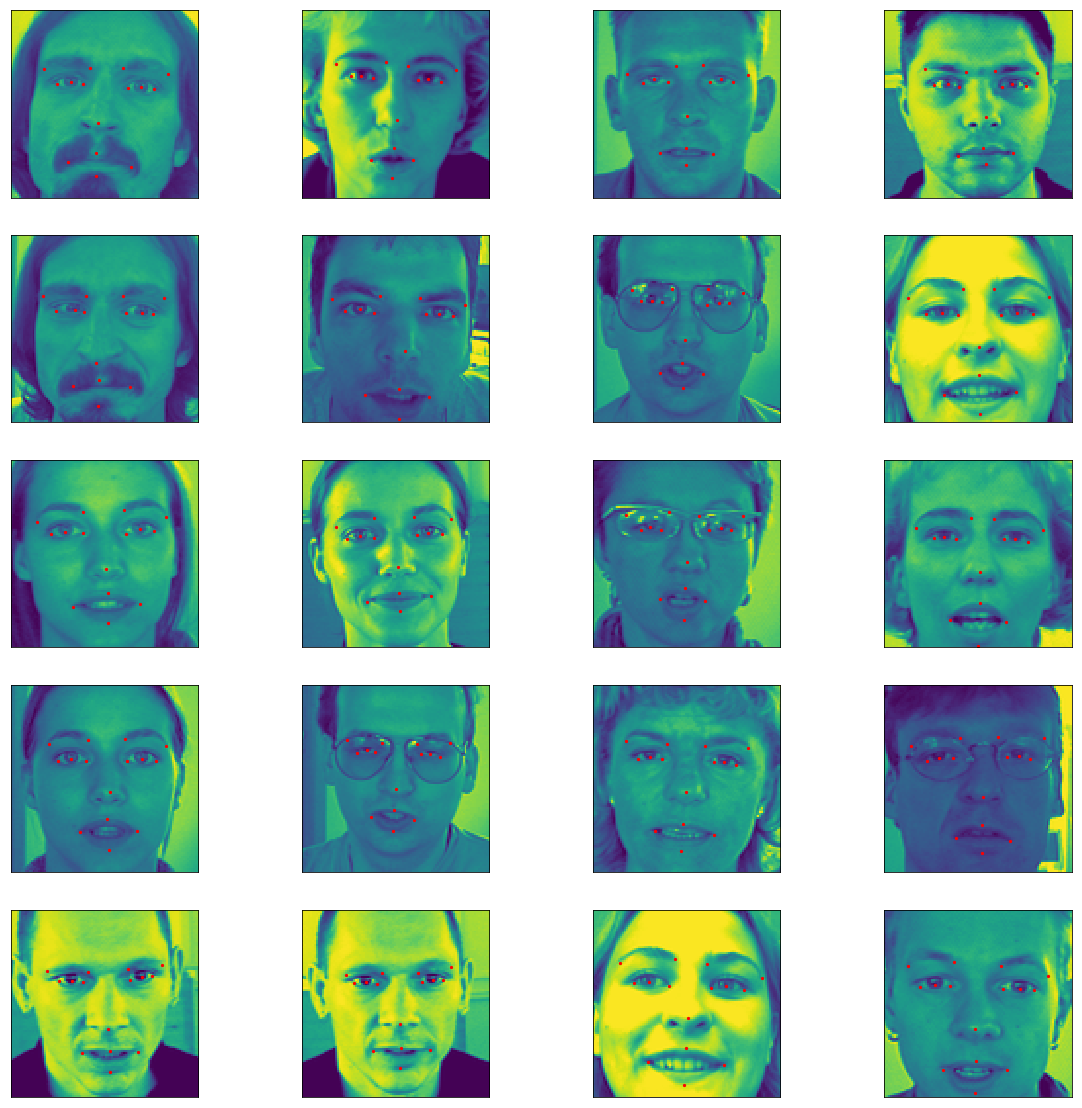

In [22]:
position = 1

fig = plt.figure(figsize = (20, 20))

for index in range(20):
    sub = fig.add_subplot(5, 4, position)
    plt.imshow(np.reshape(np.array(kaggle_train.iloc[index,:].astype(int)), (96, 96)), cmap = 'gray')
    
    for coord in range(0, labels.iloc[index,:].shape[0]-1, 2):
        if coord == None:
            continue
        else:
            plt.gca().scatter(labels.iloc[index,coord], labels.iloc[index,coord+1], c = 'red', s = 5)

    sub.set_xticks([])
    sub.set_yticks([])
    
    position += 1

plt.show()

## Splitting kaggle_train and labels into test, training and development sets

In [18]:
# How to deal with missing values?

# ignoring them?
index_none_missing = np.sum(np.isfinite(labels), axis = 1) == labels.shape[1]
kaggle_train_no_na = np.asarray(kaggle_train.loc[index_none_missing,:])
kaggle_train_no_na.shape

(2140, 9216)

Ignoring them leads to not having much observations... but a lot of features...

In [19]:
labels_no_na = np.asarray(labels.loc[index_none_missing,:])
labels_no_na.shape

(2140, 30)

In [20]:
shuffle = np.random.permutation(np.arange(kaggle_train_no_na.shape[0]))
X, Y = kaggle_train_no_na[shuffle], labels_no_na[shuffle]

# Split 60% train, 20% dev, 20% test
split_train = 0.6
split_dev_test = 0.5
test = int(X.shape[0]*split_train)
dev = int(X.shape[0]*(1-split_train)*split_dev_test) + test
test_data, test_labels = X[:test], Y[:test]
dev_data, dev_labels = X[test:dev], Y[test:dev]
train_data, train_labels = X[dev:], Y[dev:]

print(test_data.shape, test_labels.shape)
print(dev_data.shape, dev_labels.shape)
print(train_data.shape, train_labels.shape)

(1284, 9216) (1284, 30)
(428, 9216) (428, 30)
(428, 9216) (428, 30)
